In [1]:
import random
import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class Env():

    def __init__(self):
        self.actions = ["RIGHT", "UP", "DOWN", "LEFT"]
        self.max_x = 12
        self.max_y = 3
        self.start = [0, 0]
        self.goal = [self.max_x, 0]
        self.current = self.start

    def step(self, action):

        if action == "LEFT":
            self.current[0] -= 1
        elif action == "RIGHT":
            self.current[0] += 1
        elif action == "UP":
            self.current[1] += 1
        elif action == "DOWN":
            self.current[1] -= 1
        else:
            raise ValueError("Invalid action")
        
        if self.current[0] < 0:
            self.current[0] = 0
        elif self.current[0] > self.max_x:
            self.current[0] = self.max_x
    
        if self.current[1] < 0:
            self.current[1] = 0
        elif self.current[1] > self.max_y:
            self.current[1] = self.max_y

        if self.current[1] == 0 and self.current[0] not in (0, self.max_x):
            self.current = [0, 0]
            return self.current, -100, False

        if self.current == self.goal:
            return self.current, 0, True
        else:
            return self.current, -1, False
        
    def reset(self, state = None):
        if state is not None:
            self.current = state.copy()
        else:
            self.current = self.start.copy()
        return self.current
    
    def render(self):
        for y in range(self.max_y, -1, -1):
            for x in range(self.max_x + 1):
                if [x, y] == self.current:
                    print("X", end = " ")
                elif [x, y] == self.start:
                    print("S", end = " ")
                elif [x, y] == self.goal:
                    print("G", end = " ")
                else:
                    print(".", end = " ")
            print()

In [3]:
class Agent():
    """
    super class for Q-learning and SARSA agents
    """

    def __init__(self, env):
        self.env = env
        self.actions = env.actions
        self.init_q_table()

    def init_q_table(self):
        """initial q should be arbitrary value for nonterminal (s,a) and 0 for terminal
        (s,.)"""
        self.q_table = np.ones((self.env.max_x + 1, self.env.max_y + 1, len(self.actions)))
        self.q_table[self.env.goal[0], self.env.goal[1], :] = 0

    def epsilon_greedy(self, state, epsilon):
        if random.random() < epsilon:
            return random.choice(self.actions)
        else:
            return self.actions[np.argmax(self.q_table[state[0], state[1], :])]
        
    def train(self, episodes, epsilon, alpha, gamma):
        raise NotImplementedError
    
    def test(self, num_episodes = 1000, epsilon = 0):
        """
        test the learned policy
        """
        _returns = []
        for _ in range(num_episodes):
            state = self.env.reset()
            done = False
            _return = 0
            while not done:
                action = self.epsilon_greedy(state, epsilon)
                state, reward, done = self.env.step(action)
                _return += reward
            _returns.append(_return)

        return np.mean(_returns), np.std(_returns)
        
    def disp(self):
        """display the agent's policy with unicode arrows"""
        for y in range(self.env.max_y, -1, -1):
            for x in range(self.env.max_x + 1):
                if [x, y] == self.env.goal:
                    print("G", end = " ")
                else:
                    # if there's a tie, show all actions
                    if np.sum(self.q_table[x, y, :] == np.max(self.q_table[x, y, :])) > 1:
                        print("?", end = " ")
                    else:
                        action = self.actions[np.argmax(self.q_table[x, y, :])]
                        if action == "LEFT":
                            print("←", end = " ")
                        elif action == "RIGHT":
                            print("→", end = " ")
                        elif action == "UP":
                            print("↑", end = " ")
                        elif action == "DOWN":
                            print("↓", end = " ")
            print()  
        print()     

In [16]:
class QLearning(Agent):
    """
    off policy TD-learner
    """

    def train(self, num_episodes, epsilon = .2, alpha = .5 , gamma = .9):
        _returns = []
        for _ in tqdm.tqdm(range(num_episodes)):
            state = self.env.reset()
            done = False
            _return = 0
            i = 0
            while not done:
                action = self.epsilon_greedy(state, epsilon)
                next_state, reward, done = self.env.step(action)
                _return += reward
                self.q_table[state[0], state[1], self.actions.index(action)] += alpha * (reward + gamma * np.max(self.q_table[next_state[0], next_state[1], :]) - self.q_table[state[0], state[1], self.actions.index(action)])
                state = next_state
                i += 1
                if i % 1_000_000 == 0:
                    print(i)
                    self.disp()
            _returns.append(_return)
        return _returns
    
class Sarsa(Agent):
    """
    on policy TD-learner
    """

    def train(self, num_episodes, epsilon = .2, alpha = .5 , gamma = .9):
        _returns = []
        for episode in tqdm.tqdm(range(num_episodes)):
            state = self.env.reset()
            done = False
            action = self.epsilon_greedy(state, epsilon)
            _return = 0
            i = 0
            while not done:
                next_state, reward, done = self.env.step(action)
                _return += reward
                next_action = self.epsilon_greedy(next_state, epsilon)
                self.q_table[state[0], state[1], self.actions.index(action)] += alpha * (reward + gamma * self.q_table[next_state[0], next_state[1], self.actions.index(next_action)] - self.q_table[state[0], state[1], self.actions.index(action)])
                state = next_state
                action = next_action
                i += 1
                if i % 1_000_000 == 0:
                    print(i)
                    self.disp()
            _returns.append(_return)
        return _returns

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:09<00:00, 53.11it/s] 


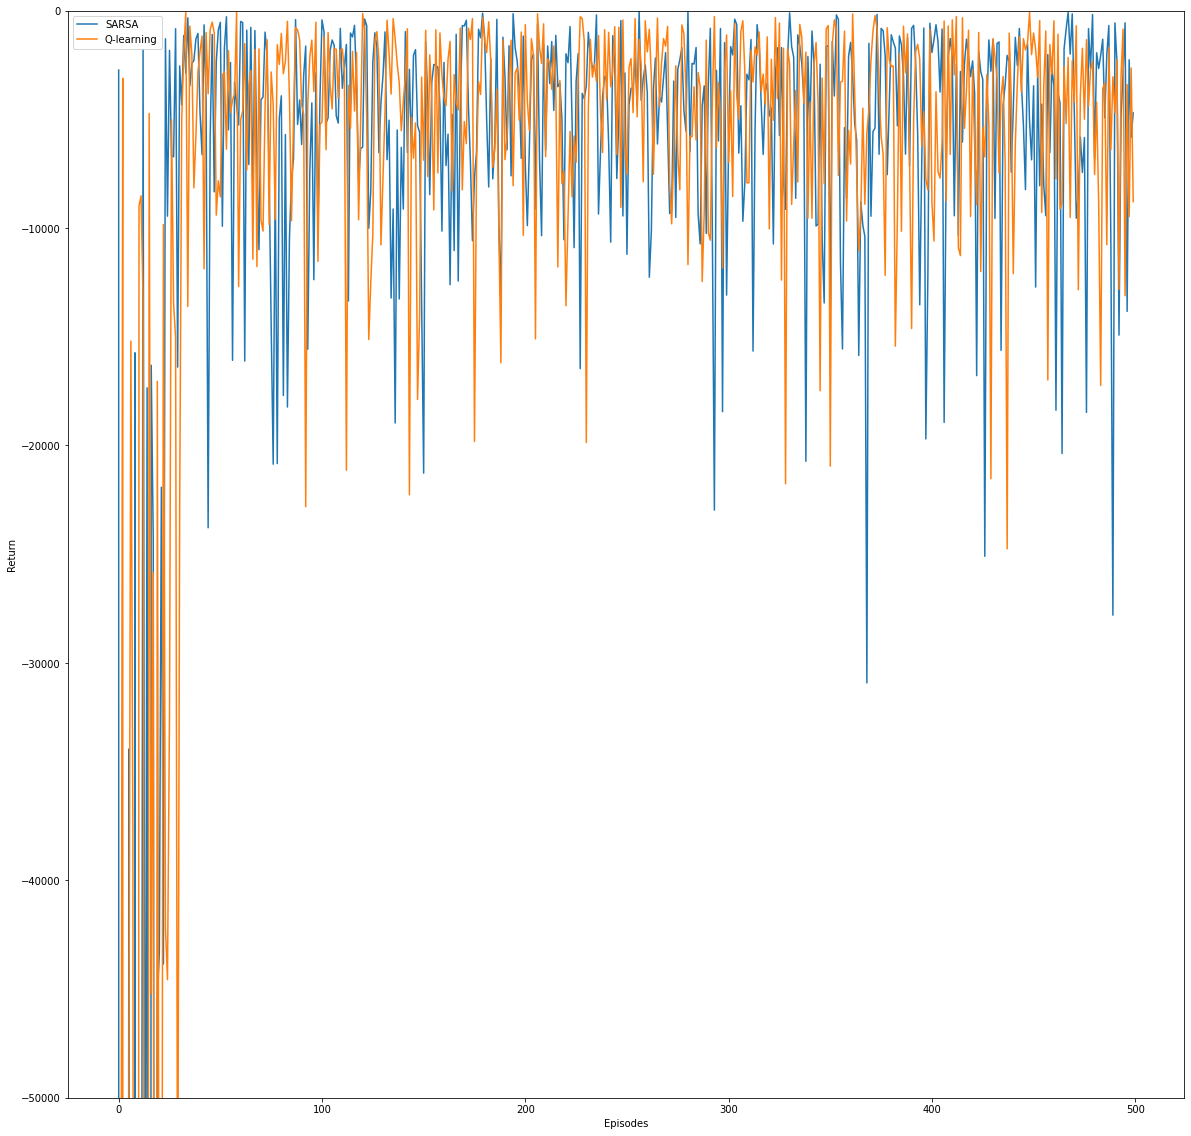

In [17]:
env = Env()
sarsa = Sarsa(env)
q_learning = QLearning(env)
num_episodes = 500
q_learning_returns = q_learning.train(num_episodes)
sarsa_returns = sarsa.train(num_episodes)

plt.figure(figsize = (20,20))
sns.lineplot(x = range(num_episodes), y = sarsa_returns, label = "SARSA")
sns.lineplot(x = range(num_episodes), y = q_learning_returns, label = "Q-learning")
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.ylim(-50000, 0)

plt.show()

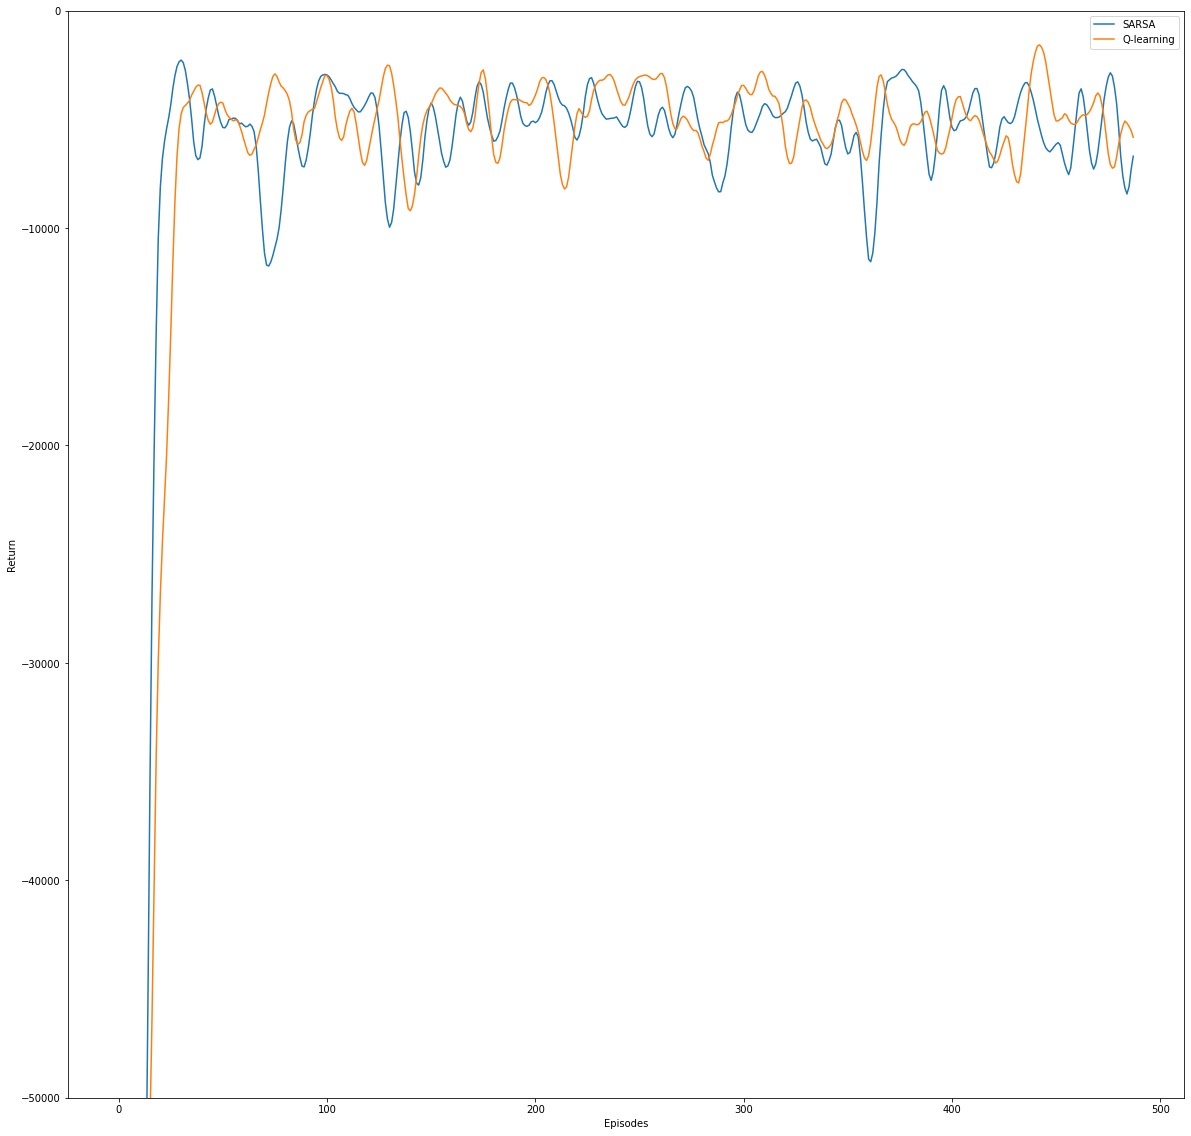

In [21]:
sarsa_returns = np.convolve(sarsa_returns, np.ones(5)/5, mode = "valid")
q_learning_returns = np.convolve(q_learning_returns, np.ones(5)/5, mode = "valid")


plt.figure(figsize = (20,20))
sns.lineplot(x = range(len(sarsa_returns)), y = sarsa_returns, label = "SARSA")
sns.lineplot(x = range(len(q_learning_returns)), y = q_learning_returns, label = "Q-learning")
plt.xlabel("Episodes")
plt.ylabel("Return")
plt.ylim(-50000, 0)

plt.show()

In [18]:
# display policies
print("SARSA")
sarsa.disp()
print("\nQ-learning")
q_learning.disp()

SARSA
? ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ? 
→ ? ? ? ? ? ? ? ? ? ? ? ← 
→ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ? 
? ? ? ? ? ? ? ? ? ? ? ? G 


Q-learning
? ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ? 
→ ? ? ? ? ? ? ? ? ? ? ? ← 
→ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ? 
? ? ? ? ? ? ? ? ? ? ? ? G 

